# Predicting Churn for Google Online Merchandise Store

Google merchandise store sells branded Google products. The traffic has been good, but the store managers notice that the majority are first-time visitors. They believe that returing visitors are more loyal to the brand, more likely to purchase, and more likely to recommend the store to their networks. Hence, they plan to run a marketing campaign to increase customer retention. In this project, I will create a model that informs the store managers which visitors have high propensity to churn, so that they can extend coupon to encourage those visitors to return 
<br>
What we hope to achieve through this project:
<li>Reduce churn rate from the current 82.6% to 50% by 12 months</li>
<li>Positive ROI on retention marketing campaign, given the cutomer life-time values</li>


# 1.Data

The dataset consists of daily entries from Jul 2016 to Jul 2017. There are more than 900K entries and 16 columns containing the following info: 
<li>Traffic source data: information about where website visitors originate. This includes data about organic traffic, paid search traffic, display traffic, etc.
<li>Content data: information about the behavior of users on the site. This includes the URLs of pages that visitors look at, how they interact with content, etc.
<li>Transactional data: information about the transactions that occur on the Google Merchandise Store website.
<p>


[Google Cloud bucket](https://console.cloud.google.com/storage/browser?project=big-query-test-350401&prefix=)

The data is available on Google Bigquery as a test dataset. I pulled the data from Bigquery and saved it in 100 slices (.parquet files) in Google Cloud bucket

[Google Colab - Data Import to Google Drive](https://colab.research.google.com/drive/1r0nej4vJNAQIXLZBpit8qkLBnPtyZpXC#scrollTo=uO9mZs7nxl8K)

I strung all the files together into a single file in Google Drive, 10 at a time due to RAM limit 

# 2.Data Cleaning

[Google Colab - Data Cleaning](https://colab.research.google.com/drive/1YyAqxCwZUnUltECHXGx8W-G6fWLYvG9l)

<li>The dataset is nested as both struct and array types. Since no machine learning models can handled nested data, I created a function to flatten the dataframe. The resulting dataframe has 307 columns in total 
<li>Among 307 columns, 158 don't contain any info (redacted) and hence should be removed
<li>4 columns contain information that are used as samples to calculate other metrics, hence not important to our objective and can be removed 
<li>Because classification models cannot handle NaN, we need to determine the values to replace NaN in each column. I decided to replace NaN with 0 for all numeric columns (transactions, visits, etc.) 
<li>Define churn: The percentages of visitors not coming back in 7/15/30 day windows follow a very similar trend. However, since Google Merchandise store sells nonessential products, few visitors would check back within 7 or 15 days. Therefore, I defined churn as the percentage of visitors not returning to the store in the next 30 days. This definition can change during peak sales periods when we expect customers to visit more often. 

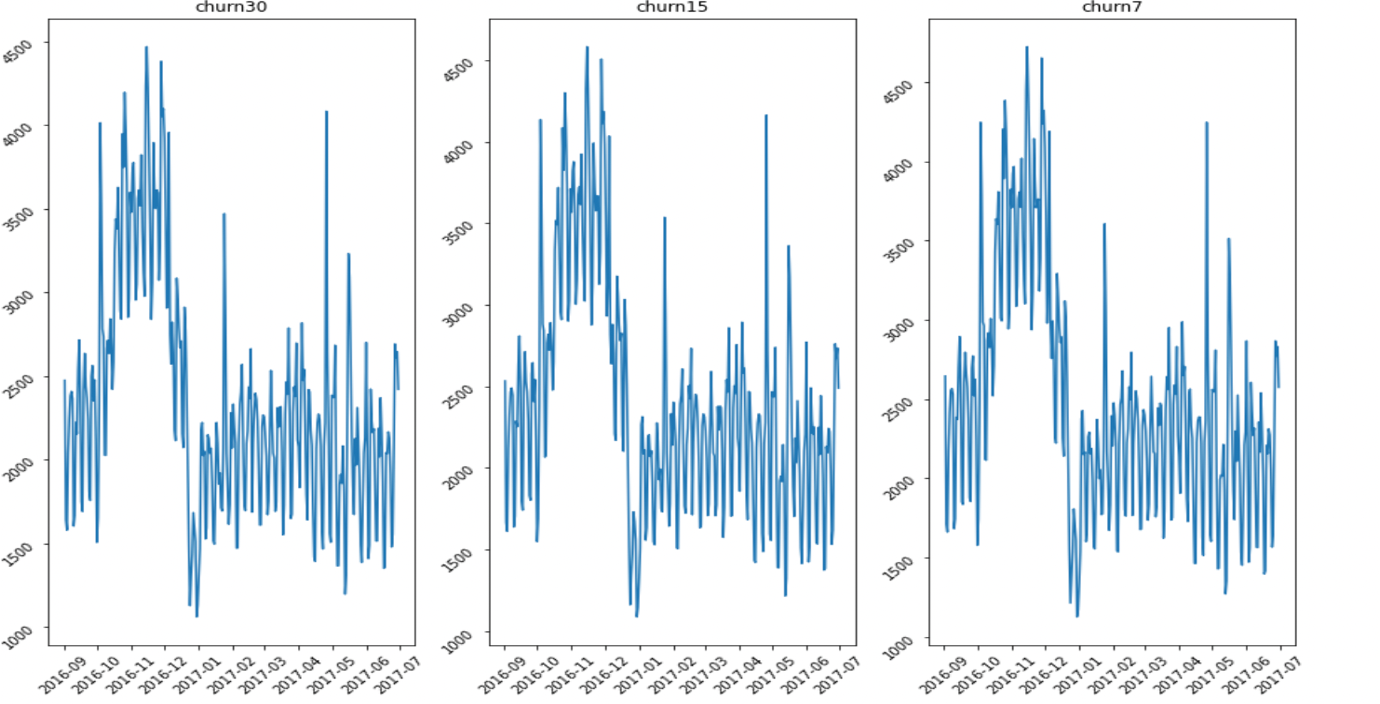

# 3.EDA & Feature Engineering

[Google Colab - EDA & Feature Engineering](https://colab.research.google.com/drive/115PsjYHYLRoCiQlLR7BgsTPEP5lKaCzo#scrollTo=YCY1k_QALRYf)

## 3.1. Initial observations

Observation 1: The data set is highly skewed, more than 80% of the samples are churned 

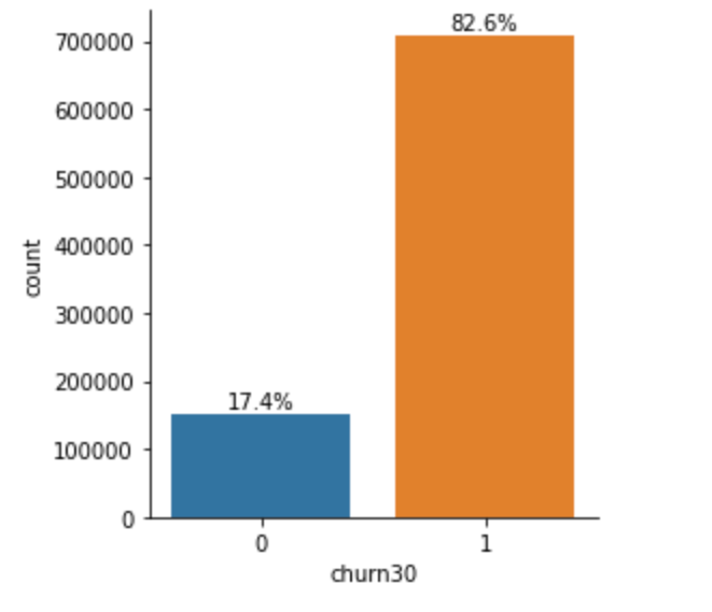

Observation 2: Display, referral, and paid have the highest not-churned to churned ratios (60%, 47.6%, 32%), whereas social has the lowest one (5.9%) 

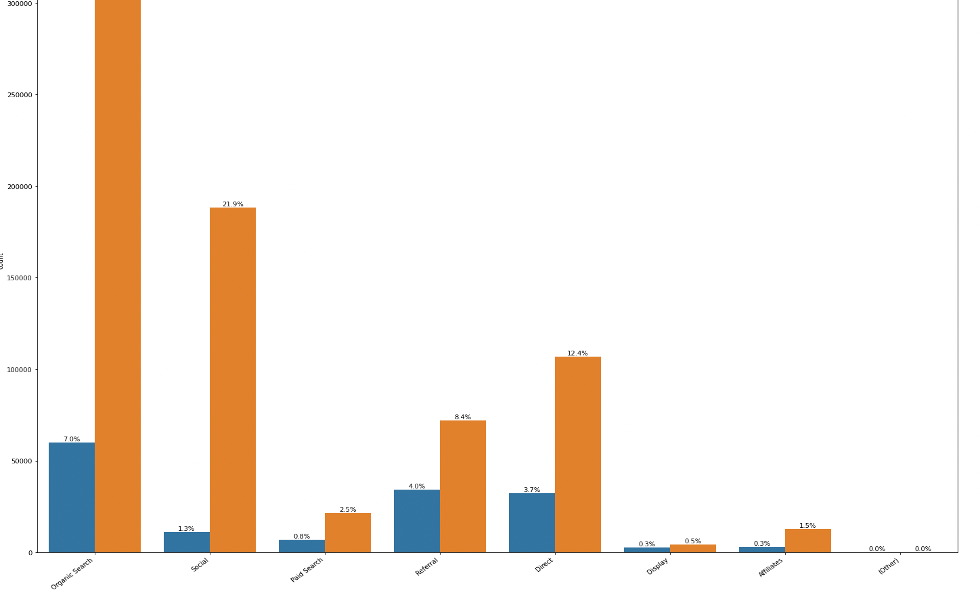

<li>Created 27 new features from the original dataset. These features either give summaries of visitors' activity frequency in the past 7/15/30 days or summaries of channels in the same time frames (e.g. total number of visits by visitor in the past 7 days, total number of visits by channel in the past 7 days) 
<li>Calculated IV for all categorical features (the sum of WOE*difference between percentages of churned and not churned for each group)
<li>Combined the high IV categorical features with continuous features, futher narrowed down to 12 features using random forest model 

## 3.2. Feature Engineering

I created 27 new features from the original dataset. These features either give summaries of visitors' activities in the past 7/15/30 days or summaries of channels in the same time frames. For example: 
<li>Total visits by a customer in the past 7/15/30 days</li>
<li>Total number of page views by a customer in the past 7/15/30 days</li>
<li>Bounce rate by a customer in the past 7/15/30 days</li>
<li>Gap between the latest 2 visits by customer</li>
<li>Gap between first and last visits by customer</li>
<li>Average visits by channel in the past 15 days</li>

## 3.3. Feature Importance Analysis

I will evaluate feature importance for categorical and continuous variables separately. I define categorical variables as those fulfilling one of these conditions: 
<li>The data type is object OR </li>
<li>There are between 2 and 20 unique values (more than 20 are too granular, hence not meaningful to classify) OR </li>
<li>Transaction data: There are fewer than 20 unique values in the dataset, but these should be treated as continuous </li>

For categorical variables, I calculated and compared their IV scores (the sum of WOE * difference between percentages of churned and not-churned in each group. For continuous variables, I used random forest model to get their feature importance scores


Figure: Continuous variables' importance scores

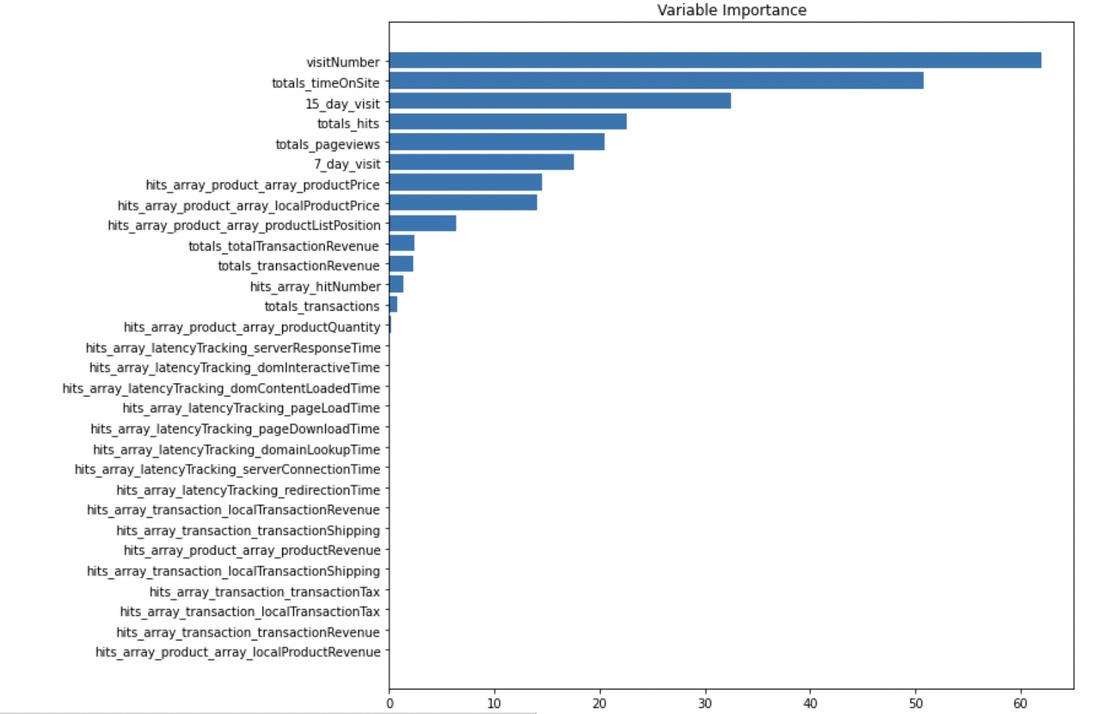

Figure: Categorical variables' importance scores

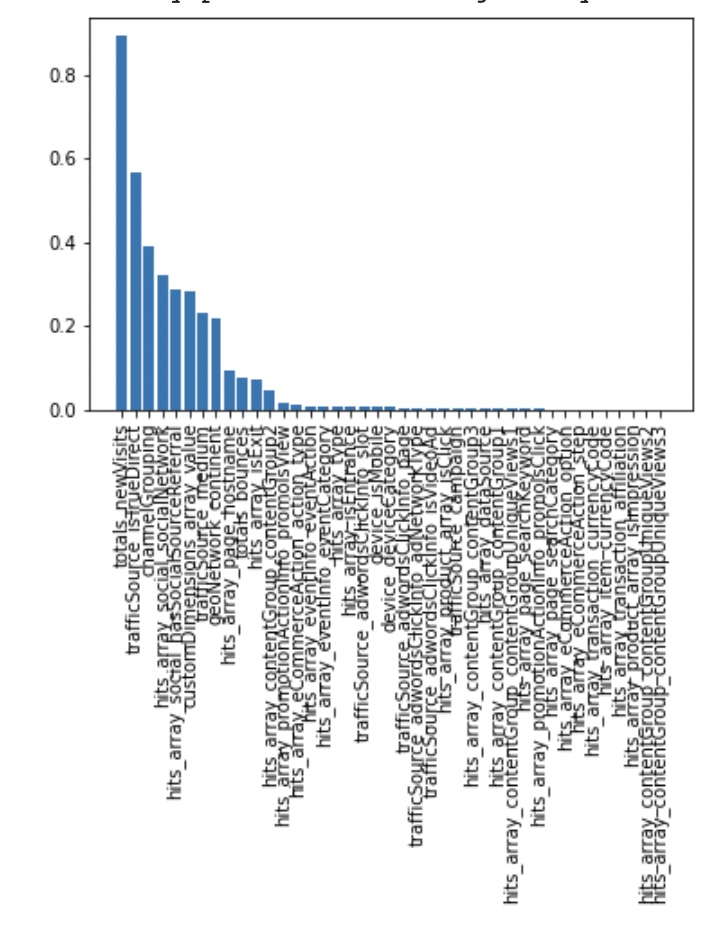

# 4.Modeling & Recommendations

[Modeling](https://colab.research.google.com/drive/1laYNlYowustBvl9DNnnd3T1YuBW_0-f6#scrollTo=nPv8OTO9eUyg)

I compared the overall performance of 3 classification models (logistics regression, random forest, and GBM) using ROC-AUC curves. GBM had the best performance with 0.81 AUC score. I then tuned the hyperparameters for GBM model, and used the best parameters to predict churn probability in the test set. 


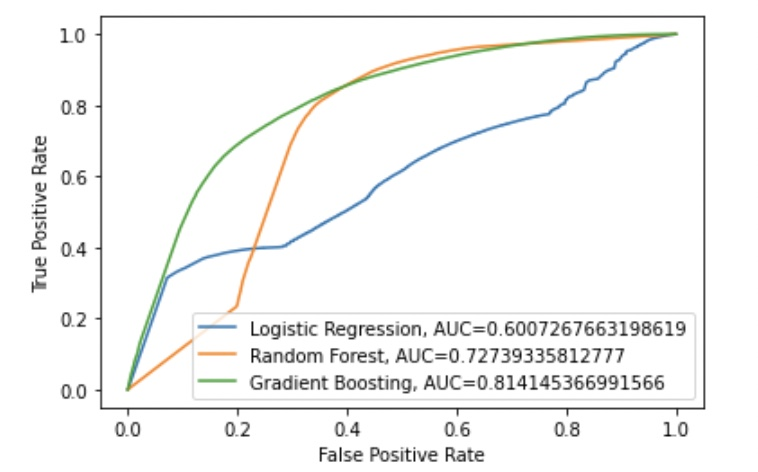

Assuming life-time value of a customer is 100 dollars if he or she does not churn and we will be spending 10 dollars per customer in our retention marketing campaign. Not churned customers tend to be more engaged and have higher chance of adopting our promo. I tested 3 scenarios:
<li>1)10% promo adoption rate among both "not churned" and "churned" groups
<li>2)10% adoption rate among the churned, 20% among the not churned group
<li>3)10% adoption rate among the churned group and 40% among the not churned group.
<br>I also assume that 20% of the high churn propensity who adopt our promo will end up not churning


Scenario 2 and 3 are more realistic: Not churned customers are those inherently interested in our products and more receptive to our marketing effort, hence we can expect them to be more likely to use the promo. 
<li>According to the simulation, profit peaks at 80th percentile for scenario 2 and 60% for scenario 3. This means in scenario 3, we can distribute coupons to 217k visitors scoring 0.6 and above to maximize profit return, if budget is not a constrainst.  
<li>In reality, marketing team is likely to have budget constrainst and depending on the projected promo redemption rate, we can decide how many people to target in the campaign.   
Assuming we are leaning toward scenario 3 and the marketing budget is $200k, we'll then decide to target the 40th percentile of population (153k people with highest probability to churn)

# 5.Next Steps

<li>1) Train model for peak sales seasons with different churn definition (shorter timeframe)</li>
<li>2) Build a web app that allows store managers to upload data and get back the list of visitors with their propensity to churn </li>